In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [2]:

# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [4]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [5]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

<AxesSubplot:>

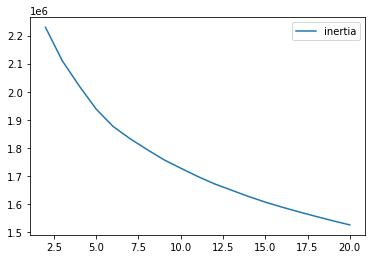

In [6]:
kMeans_inertia.plot()# Plot of intertia over 2-21 K clusters

In [8]:

# Define analyze cluster function 
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount'] #Count the number of observations per cluster
        
    preds = pd.concat([labelsDF,clusterDF], axis=1) #Join cluster dF with the true labels 
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count()) #Count the number of observations for each true label in the traning set
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0])) #Count number of observations for each label within a cluster
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent'] #store the count of the most frequently occuring label 
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster",right_on="cluster") #How tightly grouped observations are within each cluster - success metric 
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ accuracyDF.clusterCount.sum() #Define accuracy as sum of counts of the most occuring obs. divided by the total number in the set
    
    accuracyByLabel = accuracyDF.countMostFrequent/ accuracyDF.clusterCount # cluster accuracy
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [9]:
# K-means - Accuracy as the number of clusters varies

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered =pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

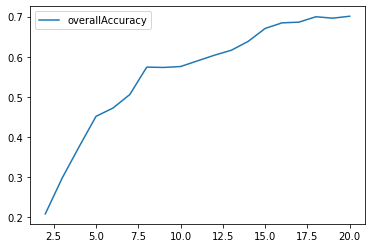

In [10]:
# Plot accuracy
overallAccuracy_kMeansDF.plot()

In [11]:
# Accuracy by cluster
accuracyByLabel_kMeans

0     0.928172
1     0.849176
2     0.874955
3     0.455545
4     0.592881
5     0.385702
6     0.932873
7     0.721638
8     0.495248
9     0.847841
10    0.891425
11    0.636328
12    0.916874
13    0.956971
14    0.942112
15    0.379933
16    0.464061
17    0.793194
18    0.528749
19    0.949918
dtype: float64

In [12]:
# View cluster labels
X_train_kmeansClustered

,cluster
0,7
1,6
2,3
3,9
4,15
...,...
49995,8
49996,13
49997,5
49998,16


In [13]:
# K-means - Accuracy as the number of Principle components varies

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]: #number of components used
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

<AxesSubplot:>

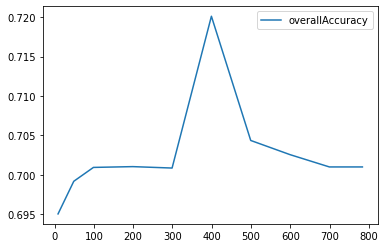

In [14]:
# Accuracy relative to number of principal components
overallAccuracy_kMeansDF.plot()

In [15]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\Users\JMcKay\AppData\Local\Temp\ipykernel_30204\2405941189.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(X_train.loc[:,0:cutoff])


<AxesSubplot:>

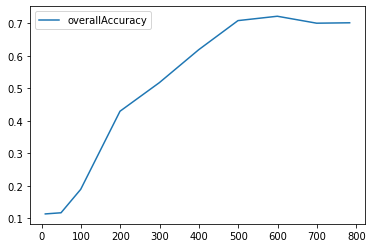

In [16]:
# Accuracy relative to number of original dimensions
overallAccuracy_kMeansDF.plot() #Requires 600 dimensions to get similar accuracy of 10 off PCA

In [17]:
# Perform hierarchical clustering
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff],method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [18]:

# Show leaves
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562682,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637667,2.0
5,20465.0,24483.0,0.662558,2.0
6,466.0,42098.0,0.664191,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675122,2.0


In [21]:
# Show leaves higher on the tree
Z_dataFrame.iloc[40000:40100]

,clusterOne,clusterTwo,distance,newClusterSize
40000,74307.0,87086.0,6.899091,6.0
40001,78891.0,83919.0,6.899560,9.0
40002,68713.0,87334.0,6.899600,10.0
40003,82163.0,83074.0,6.901224,7.0
40004,76139.0,85691.0,6.901233,6.0
...,...,...,...,...
40095,13677.0,34500.0,6.921918,2.0
40096,76680.0,84424.0,6.922157,5.0
40097,68185.0,83052.0,6.922297,20.0
40098,66007.0,77691.0,6.922900,6.0


In [25]:
# Show end of cluster
Z_dataFrame.head(-5)

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562682,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637667,2.0
...,...,...,...,...
49989,99970.0,99973.0,217.355889,4899.0
49990,99969.0,99986.0,225.468281,8270.0
49991,99981.0,99982.0,238.845174,9750.0
49992,99968.0,99977.0,266.146788,5567.0


In [29]:
# Create clusters - To compare to KMeans
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160 #Determines how many distinct clusters we want to see, the larger the distance the fewer the clusters. Data within the threshold will be in the same cluster
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

# Print number of clusters
print("Number of distinct clusters: ", len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [30]:
# Show overall accuracy of Hierarchy
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, accuracyDF_hierClust,overallAccuracy_hierClust, accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [31]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

In [32]:
# View cluster labels - Hierarchy Clustering
X_train_hierClustered

,cluster
0,5
1,3
2,15
3,11
4,14
...,...
49995,4
49996,3
49997,6
49998,14


In [33]:
# DBSCAN - is not forced to label all point and is less influenced by outliers
from sklearn.cluster import DBSCAN

eps = 3 #Maximum distance to be considered as a cluster
min_samples = 5 #Minimum number of points to create a cluster under the eps distance
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.242

In [34]:
# Print overall accuracy
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [35]:
#Show cluster results # The majority of the data is not within a cluster
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
...,...,...
95,85,4
96,57,4
97,92,4
98,54,3


In [37]:
# Perform HDBSCAN - heirarchical DBSCAN
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])

X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, countMostFreq_hdbscan, accuracyDF_hdbscan, overallAccuracy_hdbscan, accuracyByLabel_hdbscan = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

In [38]:
# Print overall accuracy HDBSCAN
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.24694


In [39]:
# Show cluster size HDBSCAN
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,42570
1,4,5140
2,6,943
3,0,605
4,7,294
5,3,252
6,1,119
7,5,45
8,2,32


In [40]:
# View cluster labels
X_train_PCA_hdbscanClustered

,cluster
0,-1
1,0
2,-1
3,4
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1
